In [102]:
include(joinpath(pwd(), "MPC_functions.jl"))
using  Luna
import FFTW                    
import Luna: Hankel  
import NumericalIntegration: integrate, SimpsonEven          
import Dates                   
using LaTeXStrings
using Printf
using DSP
using HDF5
using PyPlot
pygui(true)
using Plots
using CSV
using DataFrames


In [103]:
PyPlot.rcdefaults() # reset to default
PyPlot.close("all")

# Set global plotting parameters for PyPlot.jl
PyPlot.rc("font", size=12)      #family="serif",
# PyPlot.rc("axes", titlesize=18, labelsize=16)
# PyPlot.rc("xtick", labelsize=12)
# PyPlot.rc("ytick", labelsize=12)
PyPlot.rc("lines", linewidth=1.5)
size_py = 0.393701*[20, 15]     # figure size
size_py_wide = 0.393701*[20, 8]# figure size in cm
size_py_small = 0.393701*[20, 10]     # figure size

res = 300                       # figure resolution (dpi)

300

In [104]:
# Set global plotting parameters for Plots.jl
default(
#       guidefont = font(16, "Times"),    # Axis label font
#       tickfont = font(14),              # Axis tick font
#       legendfontsize = 12,              # Legend font size
#       titlefont = font(18, "Arial"),    # Title font
        linewidth=2
  )
size_jl=(800,600)   # figure size in pixel
# closeall()


(800, 600)

In [105]:
out_path = joinpath(pwd(), "..", "..", "thesis")
save_figs = false


false

## READ IN RESULTS FROM ESMERANDOS 1D CODE

RESULTS WITH n2 from Daher et al.

In [106]:
using DelimitedFiles

# Reading results from Esmerandos script
dir_path = joinpath("output_thesis", "2025-08-13_11-00-31") #"2025-07-23_14-53-30")

#spectrum
file = joinpath(dir_path, "output_spectrum.txt")
data = readdlm(file, '\t', skipstart=1)
λ_esm = data[:,1].*1e-9   
Iλ_esm = data[:,2]
ϕω_esm = data[:,3]

# pulse temporal
file = joinpath(dir_path, "output_pulse.txt")
data = readdlm(file, '\t', skipstart=1) 
t_esm = data[:,1]
It_esm = data[:,2] 
ϕt_esm = data[:,3]

8192-element Vector{Float64}:
  1.84621160437283
  1.89033590208799
  1.93992063261896
  1.99500663732647
  2.05556259141334
  2.1212157571076
  2.19142859592152
  2.26533822153654
  2.34193382041302
  2.41988272930259
  ⋮
 20.5020942453698
 20.5088054013882
 20.5186612791475
 20.5318436702701
 20.5486081860195
 20.5692080482958
 20.5939249159504
 20.6230569407345
 20.656893143143

RESULTS WITH SAME n2 AS LUNA USES

In [107]:
using DelimitedFiles

# Reading results from Esmerandos script
dir_path = joinpath("output_thesis", "2025-08-05_13-20-22") #"2025-07-23_14-48-11")

#spectrum
file = joinpath(dir_path, "output_spectrum.txt")
data = readdlm(file, '\t', skipstart=1)
λ_esm_n2 = data[:,1].*1e-9   
Iλ_esm_n2 = data[:,2]
ϕω_esm_n2 = data[:,3]

# pulse temporal
file = joinpath(dir_path, "output_pulse.txt")
data = readdlm(file, '\t', skipstart=1) 
t_esm_n2 = data[:,1]
It_esm_n2 = data[:,2] 
ϕt_esm_n2 = data[:,3]

8192-element Vector{Float64}:
  2.21948498436346
  2.2180919000786
  2.2183864698028
  2.22039239926183
  2.2241968408378
  2.22989502529845
  2.23758557058134
  2.24741988038261
  2.25950276551907
  2.27409220574129
  ⋮
 39.9973945702819
 39.9835950818763
 39.9708782621125
 39.959290054564
 39.9489645705715
 39.9399571997333
 39.932370538778
 39.9262288032298
 39.9216359060867

## PAPER DATA

In [108]:
df = CSV.read(joinpath("input", "paper_caus_3.0_Xe.csv"), DataFrame)
z_caus = df[:,1]
caus = df[:,2]

df = CSV.read(joinpath("input", "paper_spec_3.0_Xe.csv"), DataFrame)
lamb = df[:,1]
spec = df[:,2]

println(caus[1])

0.5469130378243092


## I) Read data from .h5 file

In [109]:
run = "run_2025_07_21__16_50_18" #"run_2025_08_13__11_01_56" #
run_path = joinpath("output_thesis", run)

params = Dict()

# Open file read-only
h5open(joinpath(run_path, "output.h5"), "r") do file
    # List datasets/groups in the file
    println(keys(file))
    
    # Read dataset
    global Eωr0 = read(file["Eωr0"])
    global Eωr_in = read(file["Eωr_in"])
    global Eωr_out = read(file["Eωr_out"])

    # Read beam waists
    global w_z = read(file["w_z"]) 
    global w_min = read(file["w_min"]) 
    global w_mirr = read(file["w_mirr"]) 
    
    global ω = read(file["ω"])
    global t = read(file["t"])
    global r = read(file["r"])
    global z = read(file["z"])

    # file["params"] is a group with keys as parameter names
    param_group = file["params"]
    for name in keys(param_group)
        params[name] = read(param_group[name])
    end
end

["Eωr0", "Eωr_in", "Eωr_out", "params", "r", "t", "w_min", "w_mirr", "w_z", "z", "ω"]


Regenerate Hankel transform matrix "q", simulation grid as well as additional coordinate axes rsym, f and λ

In [110]:
q = Hankel.QDHT(params["R_Hankel"], params["N_Hankel"], dim=2)                  # set up discrete Hankel transform matrix, transformation done along 2nd dimension 
q_1D = Hankel.QDHT(params["R_Hankel"], params["N_Hankel"], dim=1)               # to be applied to arrays that where integrated over ω, so r becomes 1rst dimension
rsym = Hankel.Rsymmetric(q)                                 # sampled radii [m] mirrored around and including r=0 so that rsym = [–rn, ...-r2, -r1, 0, r1, r2, ..., rn]

L = params["L"]
λ0 = params["λ0"]
λlims = (params["λmin"], params["λmax"])
trange_request = params["trange_request"]

grid = Grid.RealGrid(L, λ0, λlims, trange_request)               # set up time & space grid for gradient approximation
f = ω./2π                      # sampled linear frequencies [Hz]
λ = PhysData.wlfreq.(ω)         # sampled wavelengths [m]
λ[1] = 1.0                        # avoid "Inf" value for DC frequency

┌ Info: Freq limits 0.26 - 0.33 PHz
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:40
┌ Info: Samples needed: 3997.23, samples: 4096, δt = 500.35 as
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:44
┌ Info: Requested time window: 2000.0 fs, actual time window: 2049.4 fs
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:46
┌ Info: Grid: samples 2048 / 4096, ωmax 3.14e+15 / 6.28e+15
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:78


1.0

## II) Analyze final output (last propagation step of last pass)

### a) Input vs. output spectrum and spectral phase

In [111]:
Eωr0_in = Eωr0[:,1,1]
Eωr0_out = Eωr0[:,end,end]

1025-element Vector{ComplexF64}:
   0.024317660500190255 + 0.0im
  -0.022356707408104033 - 0.009577906547839096im
    0.01679078029191618 + 0.017613725815535712im
  -0.008518603328103662 - 0.02281624353826435im
 -0.0011267300305799813 + 0.024354380883181405im
   0.010595864893663258 - 0.021990268917393845im
    -0.0183755248470167 + 0.01611449395123834im
    0.02323310299221051 - 0.007678283511375991im
  -0.024413174793075653 - 0.001965210483578343im
    0.02175398693777516 + 0.011283400670719163im
                        ⋮
  -0.008373006702760718 + 0.002591499220443265im
   0.008475868574888771 - 0.0025561616975546507im
  -0.009526517812127488 + 0.002048584014530907im
   0.010953255162631771 - 0.0005308119130597051im
  -0.012012706006305027 - 0.002116032776550104im
    0.01203014407709592 + 0.0055841883477862515im
  -0.010602691825443617 - 0.009248742152192048im
   0.007715682429718837 + 0.012358467186002503im
  -0.003746338773428801 - 0.014254050944656198im

In [112]:
ϕω_in = unwrap_phase(ω, t, Eωr0_in)
ϕω_out = unwrap_phase(ω, t, Eωr0_out)

ϕω_in = blank_phase(ω, abs2.(Eωr0_in), ϕω_in; level=0.05)
ϕω_out = blank_phase(ω, abs2.(Eωr0_out), ϕω_out; level=0.05)

1025-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [ ]:
plt.figure(figsize=size_py_small)
# plt.title("Output spectrum comparison")
plt.fill_between(lamb, spec, label="Daher et al.", alpha=0.5, color="grey")
plt.plot(λ.*1e9, Maths.normbymax(abs2.(Eωr0_out)), label="Luna", color="blue")#, alpha=0.5)
# plt.plot(λ_esm_n2.*1e9, Maths.normbymax(Iλ_esm_n2), label="1D (n2 Luna)", color="green")
plt.plot(λ_esm.*1e9, Maths.normbymax(Iλ_esm), label="1D", color="red")#, alpha=0.5)
plt.xlim(950, 1100)
plt.ylim(0, 1)
# plt.xlim(980, 1080)#λlims[1]*1e9, λlims[2]*1e9)
plt.xlabel("λ [nm]")
plt.ylabel("Intensity [norm.]")
plt.legend(loc="upper left")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(out_path, "spec_3.0_Xe_comp.png"), dpi=res) 
end
plt.gcf()

### b) Input vs. output pulse

In [114]:
Etr0_in = Maths.hilbert(FFTW.irfft(Eωr0_in, length(t), 1))
Etr0_out = Maths.hilbert(FFTW.irfft(Eωr0_out, length(t), 1))

ϕt_in = unwrap(angle.(Etr0_in))
ϕt_out = unwrap(angle.(Etr0_out))

ϕt_in = blank_phase(t, abs2.(Etr0_in), ϕt_in; level=0.05)
ϕt_out = blank_phase(t, abs2.(Etr0_out), ϕt_out; level=0.05)

2048-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

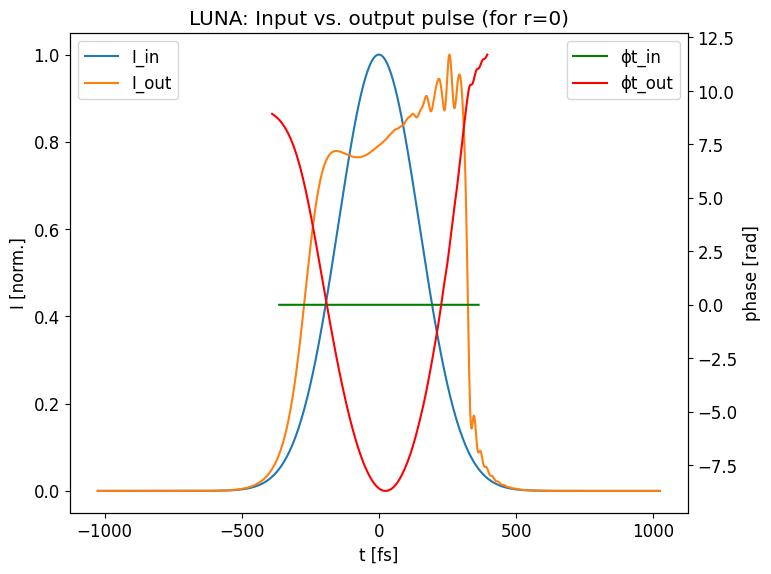

In [115]:
fig, ax1 = plt.subplots(figsize=size_py)
ax1.set_title("LUNA: Input vs. output pulse (for r=0)")
ax1.plot(t.*1e15, Maths.normbymax(abs2.(Etr0_in)), label="I_in")
ax1.plot(t.*1e15, Maths.normbymax(abs2.(Etr0_out)), label="I_out")
ax2 = ax1.twinx()
ax2.plot(t.*1e15, detrend(ϕt_in), label="ϕt_in", color="green")
ax2.plot(t.*1e15, detrend(ϕt_out), label="ϕt_out", color="red")
# ax1.set_xlim(-200, 200)
ax1.set_xlabel("t [fs]")
ax1.set_ylabel("I [norm.]")
ax2.set_ylabel("phase [rad]")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "pulse_in_vs_out.png"), dpi=res) 
end
plt.gcf()

### c) Spectral homogeinity across r

In [116]:
Irλ_out = transpose(Iwlfreq.(ω, abs2.(Eωr_out)))

256×1025 transpose(::Matrix{Float64}) with eltype Float64:
 0.0  2.0227e12   8.08085e12  …  1.59994e19  1.63167e19  1.64448e19
 0.0  5.64968e10  2.26337e11     4.66723e18  4.72804e18  4.75463e18
 0.0  8.80205e11  3.50443e12     6.02994e18  6.14756e18  6.19519e18
 0.0  1.75338e11  6.96164e11     5.59905e17  5.64641e17  5.6697e17
 0.0  6.0158e11   2.39513e12     1.0451e16   3.1095e15   6.85788e14
 0.0  1.43675e11  5.72887e11  …  2.47643e17  2.46254e17  2.4612e17
 0.0  2.74332e11  1.09163e12     4.43034e18  4.48561e18  4.51001e18
 0.0  1.73383e11  6.90782e11     3.07057e18  3.12451e18  3.14674e18
 0.0  5.74286e10  2.30255e11     5.57563e17  5.60117e17  5.61706e17
 0.0  1.18936e11  4.76536e11     1.56441e18  1.58494e18  1.59392e18
 ⋮                            ⋱                          
 0.0  4.55451e9   1.8086e10      4.18102e15  3.96096e15  3.89293e15
 0.0  5.81055e7   2.38806e8      2.39452e16  2.38049e16  2.3789e16
 0.0  1.50566e9   5.97614e9      2.86903e16  2.85570e16  2.85496e16
 0

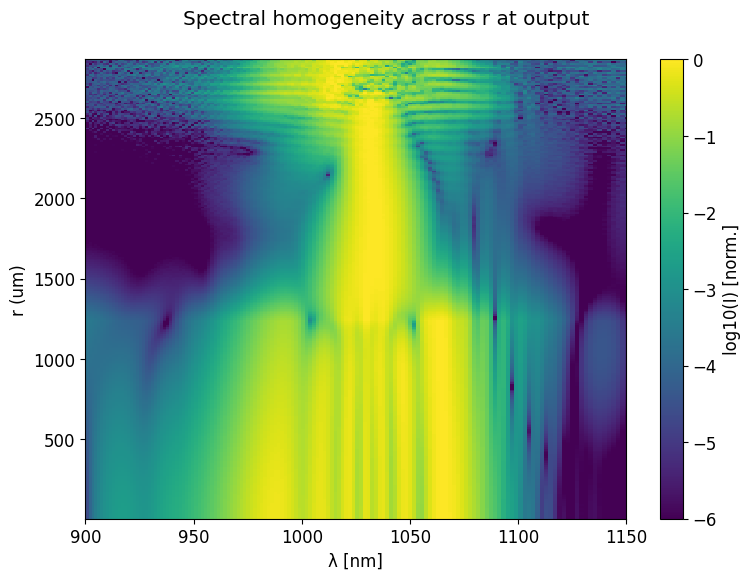

In [117]:
smallval = 1e-50

plt.figure(figsize=size_py)
plt.suptitle("Spectral homogeneity across r at output")
plt.pcolormesh(λ*1e9, r*1e6, Maths.log10_norm(Irλ_out .+smallval, 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log10(I) [norm.]")
plt.xlim(λlims[1]*1e9, λlims[2]*1e9)
plt.xlabel("λ [nm]")
plt.ylabel("r (um)") 
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_homogeneity.png"), dpi=res) 
end
plt.gcf()

### d) Spatiotemporal profile

In [118]:
Etr_out = Maths.hilbert(FFTW.irfft(Eωr_out, length(t), 1))

2048×256 Matrix{ComplexF64}:
 -16318.7-1399.3im   -3686.63+3640.61im  …   57.8924-765.052im
  6286.29-15380.8im  -3432.85-4320.78im      621.953+200.788im
  12982.9+10609.2im   4929.11-3084.2im      -270.298+456.497im
 -13898.5+9388.48im   2612.89+5478.71im     -296.927-266.952im
 -5027.21-15810.7im  -5952.91+2041.37im      200.958-169.146im
  16190.0-428.108im  -1384.96-6346.21im  …   93.7866+90.6387im
 -3868.17+15092.2im   6652.72-647.907im      39.7808+83.8439im
 -12764.8-7396.89im   -170.48+6854.89im     -142.915+162.926im
  9836.07-9592.88im  -6919.12-1062.47im     -251.489-264.232im
  6024.21+11039.8im   1997.71-6801.93im       430.76-281.791im
         ⋮                               ⋱          ⋮
  9993.55-15668.0im   1793.79+370.983im      887.175+1025.08im
  11913.3+13199.8im  -508.567+2297.88im  …  -1205.05+572.371im
 -15310.8+7546.02im  -2665.94-754.991im     -227.189-1280.33im
 -2838.98-16246.5im   1039.02-2930.86im      1249.25+114.07im
  15965.5+1937.75im   3141.78+1336.3

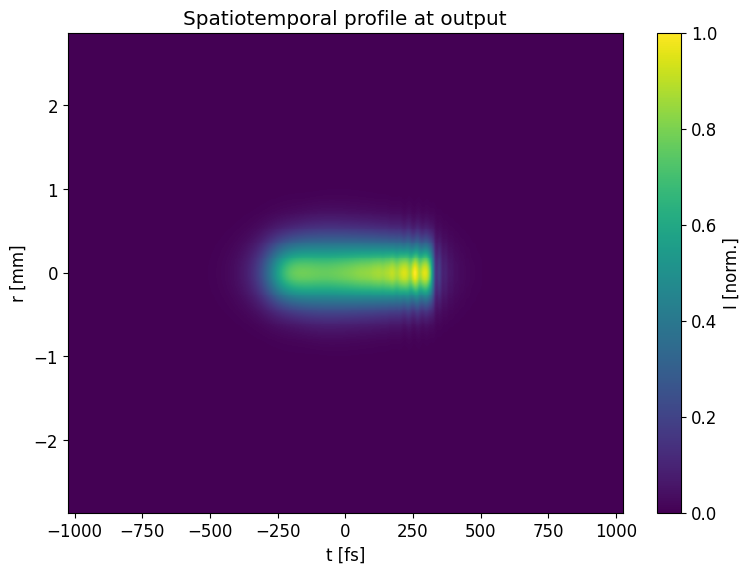

In [119]:
plt.figure(figsize=size_py) 
plt.title("Spatiotemporal profile at output")
plt.pcolormesh(t.*1e15, rsym.*1e3, Maths.normbymax(abs2.(Hankel.symmetric(Etr_out, q)')))
plt.colorbar(label="I [norm.]")
plt.xlabel("t [fs]")
plt.ylabel("r [mm]")
# plt.ylim(minimum(rsym*1e3), maximum(rsym*1e3))
# plt.xlim(minimum(t*1e15)/2, maximum(t*1e15)/2)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spatiotemporal_profile.png"), dpi=res) 
end
plt.gcf()

## III) Analyze overall pulse evolution across all passes

In [120]:
Nω = size(Eωr_in,1)
Nr = size(Eωr_in,2)
Nz = size(Eωr0,2)
Npass = size(Eωr0,3)

Nt = length(t)
Nrsym = length(rsym)

513

In [121]:
z_total = zeros(Nz, Npass)

for pass in 1:Npass 
    z_total[:,pass] = z .+ (pass-1)*z[end]
end

z_total = vcat(z_total...)

2010-element Vector{Float64}:
 0.0
 0.002755
 0.00551
 0.008265
 0.01102
 0.013775
 0.01653
 0.019285
 0.02204
 0.024795
 ⋮
 5.48796
 5.490715000000001
 5.49347
 5.496225000000001
 5.49898
 5.501735
 5.5044900000000005
 5.507245
 5.510000000000001

### a) Beams Caustic 

In [122]:
w0 = params["w0"]
wm = params["wm"]

0.000574305774561296

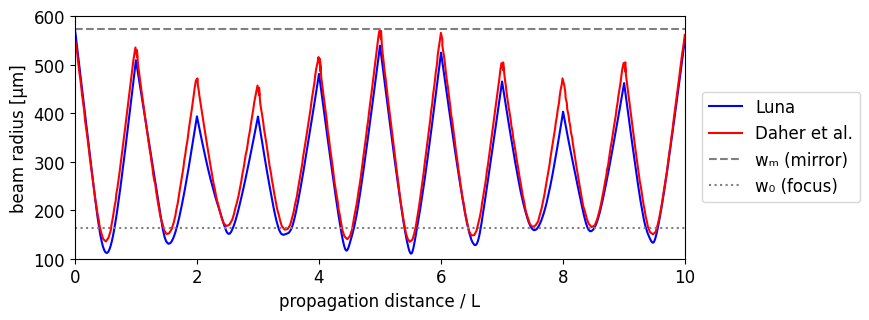

In [150]:
# PLOT CAUSTIC
plt.figure(figsize=size_py_wide) 
# plt.title("Caustic")
plt.plot(z_total./L, w_z.*1e6, label="Luna", linestyle="-", color="blue", linewidth=1.5)
plt.plot(z_caus./L, caus.*1e3, label="Daher et al.", color="red", linewidth=1.5)
plt.axhline(y=wm*1e6, color="grey", linestyle="dashed", linewidth=1.5, label="wₘ (mirror)")
plt.axhline(y=w0*1e6, color="grey", linestyle="dotted", linewidth=1.5, label="w₀ (focus)")
plt.xlabel("propagation distance / L")
plt.ylabel("beam radius [μm]")
# plt.xlim(0,maximum(z_total.*1e2))
plt.xlim(0,10)
plt.ylim(100, 600)
plt.legend(loc="lower right", bbox_to_anchor=(1.30, 0.2))
# plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(out_path, "caus_3.0_Xe_comp.png"), bbox_inches="tight", dpi=res) 
end
plt.gcf()

<!-- ### b) Minimum beam waist per pass -->

In [124]:
println(caus[1]*1e6)
println(w_z[1]*1e6)

546913.0378243092
574.3053496818428


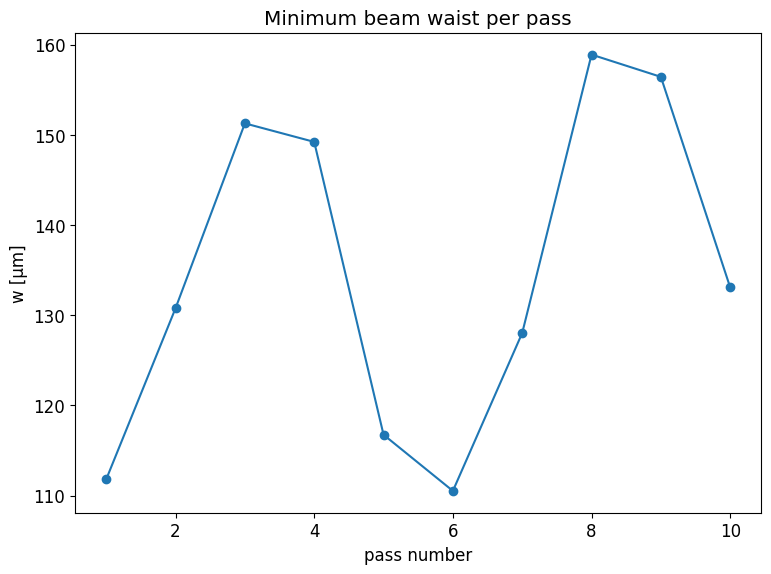

In [125]:
# PLOT minimum beam waist per pass
plt.figure(figsize=size_py) 
plt.title("Minimum beam waist per pass")
plt.plot(1:Npass, w_min.*1e6, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("w [μm]")
# plt.ylim(95,125)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "beam_waist_minimum.png"), dpi=res) 
end
plt.gcf()

### c) Mirror beam waist per pass

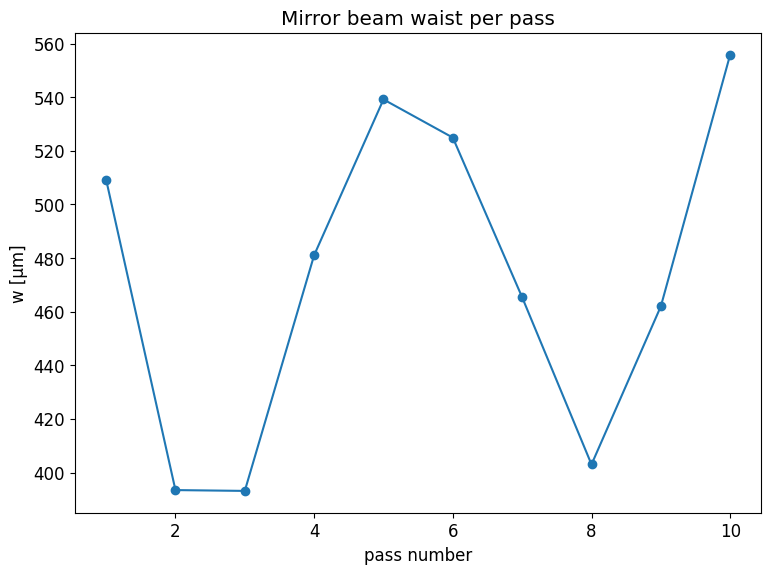

In [126]:
# PLOT mirror beam waist per pass
plt.figure(figsize=size_py) 
plt.title("Mirror beam waist per pass")
plt.plot(1:Npass, w_mirr.*1e6, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("w [μm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

### d) Spectral evolution (vs. λ)

In [127]:
Iωr0 = abs2.(Eωr0)    # convert to intensity
Iλr0 = Iwlfreq.(ω, Iωr0)

1025×201×10 Array{Float64, 3}:
[:, :, 1] =
 0.0         0.0         0.0         …  0.0         0.0         0.0
 1.40147e23  2.27929e15  6.75446e15     1.19747e14  3.97808e13  1.32154e13
 1.98595e23  3.62573e16  3.35276e16     4.74329e14  1.57575e14  5.23474e13
 2.35208e22  1.82139e17  9.96063e16     1.05057e15  3.49004e14  1.15941e14
 1.0616e24   5.69586e17  2.36332e17     1.82913e15  6.07647e14  2.01864e14
 1.608e24    1.37184e18  4.85907e17  …  2.78829e15  9.26285e14  3.07718e14
 1.79395e24  2.79773e18  8.99761e17     3.90887e15  1.29855e15  4.31387e14
 8.42533e24  5.08189e18  1.5365e18      5.18004e15  1.72084e15  5.71674e14
 1.87989e25  8.47345e18  2.45946e18     6.60565e15  2.19444e15  7.29005e14
 3.29854e24  1.32236e19  3.73398e18     8.21029e15  2.72751e15  9.06094e14
 ⋮                                   ⋱                          ⋮
 8.13447e29  8.15026e24  2.13995e25     4.33845e22  1.44126e22  4.78795e21
 8.1617e29   8.78485e24  2.30387e25     4.60146e22  1.52863e22  5.07821e2

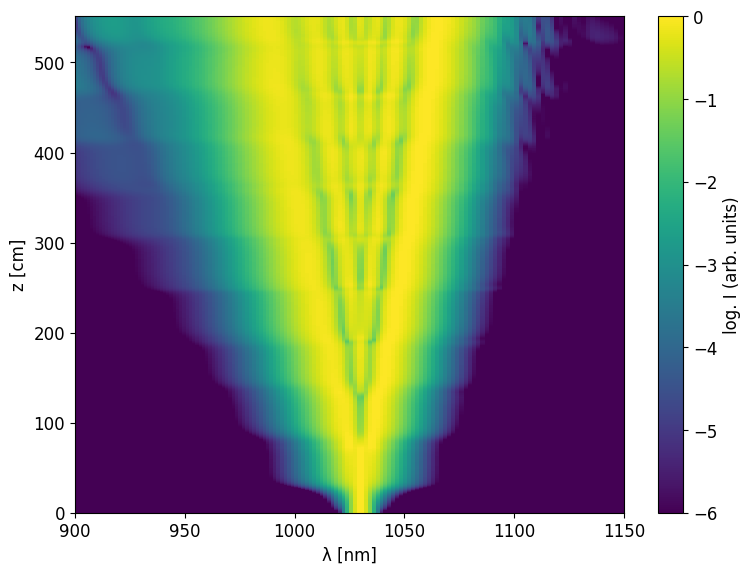

In [128]:
Iλr0_fused = hcat(eachslice(Iλr0, dims=3)...)

#+++++ PLOT 4: spectral evolution (against λ) 
plt.figure(figsize=size_py)
# plt.suptitle("Spectral evolution at r=0")
plt.pcolormesh(λ.*1e9, z_total.*1e2, Maths.log10_norm(transpose(Iλr0_fused[:, :] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(λlims[1]*1e9, λlims[2]*1e9)
# plt.ylim(0,75)
plt.xlabel("λ [nm]")
plt.ylabel("z [cm]")
# plt.xlim(700,1400)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_evolution_wl.png"), dpi=res) 
end
plt.gcf()


In [129]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(λ.*1e9, Maths.normbymax(Iλr0_fused[:, i]),
#     # size=size_jl,
#     xlim=(λlims[1]*1e9, λlims[2]*1e9), 
#     ylim=(0, 1), 
#     xlabel=("λ [nm]"),
#     ylabel=("I [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2, digits=1)) cm", 
#     title="Spectral evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "spectral_evolution.gif"), fps=24)

In [130]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(λ.*1e9, Maths.log10_norm(Iλr0_fused[:, i] .+smallval), 
#     # size=size_jl,
#     xlim=(λlims[1]*1e9, λlims[2]*1e9), 
#     ylim=(-6, 0), 
#     xlabel=("λ [nm]"),
#     ylabel=("log10(I) [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2, digits=1)) cm", 
#     title="Spectral evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "spectral_evolution_log.gif"), fps=24)

### E) Spectral evolution (vs. f)

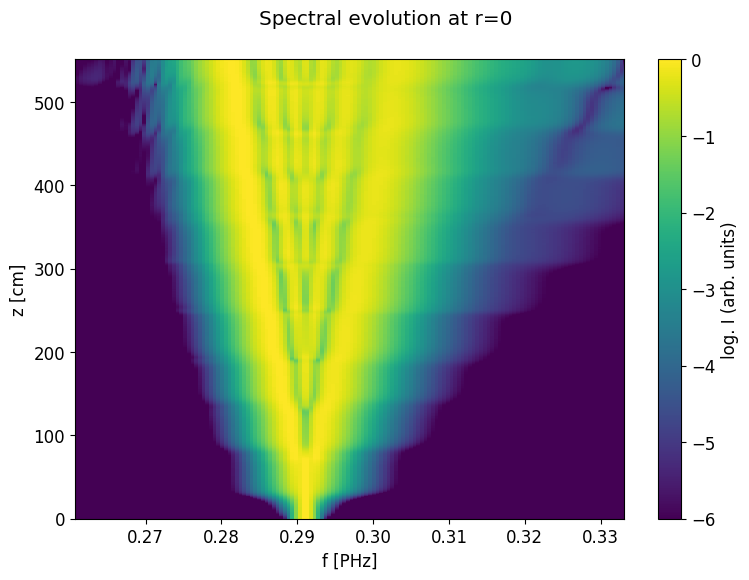

In [131]:
Iωr0_fused = hcat(eachslice(Iωr0, dims=3)...)

#+++++ PLOT 5: spectral evolution (against f) 
plt.figure(figsize=size_py)
plt.suptitle("Spectral evolution at r=0")
plt.pcolormesh(f*1e-15, z_total.*1e2, Maths.log10_norm(transpose(Iωr0_fused[:, :] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(PhysData.wlfreq(λlims[2])/2pi*1e-15, PhysData.wlfreq(λlims[1])/2pi*1e-15)
plt.xlabel("f [PHz]")
plt.ylabel("z [cm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_evolution_f.png"), dpi=res) 
end
plt.gcf()

### f) Temporal evolution

In [132]:
Etr0 = zeros((size(Eωr0,1)-1)*2, size(Eωr0,2), size(Eωr0,3))
Itr0 = similar(Etr0)

for pass in 1:size(Eωr0,3)
    Etr0[:,:,pass] = FFTW.irfft(Eωr0[:,:,pass], length(t), 1)  # pulse for r=0
    Itr0[:,:,pass] = abs2.(Maths.hilbert(Etr0[:,:,pass]))           # temporal intensity for r=0
end

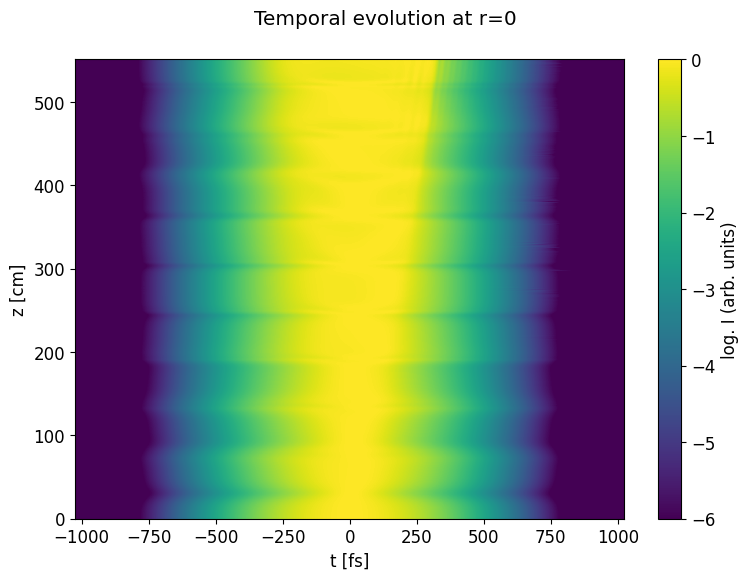

In [133]:
Itr0_fused = hcat(eachslice(Itr0, dims=3)...)

#+++++ PLOT 4: temporal evolution 
plt.figure(figsize=size_py)
plt.suptitle("Temporal evolution at r=0")
plt.pcolormesh(t.*1e15, z_total.*1e2, Maths.log10_norm(transpose(Itr0_fused[:,:] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(minimum(t)*1e15, maximum(t)*1e15)
plt.xlabel("t [fs]")
plt.ylabel("z [cm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "temporal_evolution.png"), dpi=res) 
end
plt.gcf()

In [134]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(t.*1e15, Maths.normbymax(Itr0_fused[:, i]),
#     # size=size_jl,
#     ylim=(0, 1), 
#     xlabel=("t [fs]"),
#     ylabel=("I [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2)) cm", 
#     title="Temporal evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "temporal_evolution.gif"), fps=24)

In [135]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(t.*1e15, Maths.log10_norm(Itr0_fused[:, i] .+smallval),
#     # size=size_jl,
#     ylim=(-6, 0), 
#     xlabel=("t [fs]"),
#     ylabel=("log10(I) [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2)) cm", 
#     title="Temporal evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "temporal_evolution_log.gif"), fps=24)

## B-Integral

In [136]:
I_peak = dropdims(maximum(Itr0, dims=1), dims=1)

201×10 Matrix{Float64}:
 7.80698e17  1.0784e18   2.16202e18  …  1.08682e18  1.3525e18   9.07859e17
 7.95211e17  1.09417e18  2.1935e18      1.1061e18   1.37356e18  9.27549e17
 8.10127e17  1.11032e18  2.2259e18      1.12588e18  1.395e18    9.47754e17
 8.25512e17  1.12675e18  2.25826e18     1.14609e18  1.41692e18  9.6866e17
 8.41382e17  1.14364e18  2.29221e18     1.16694e18  1.43903e18  9.9019e17
 8.5759e17   1.16067e18  2.32483e18  …  1.18815e18  1.46203e18  1.01242e18
 8.74273e17  1.1783e18   2.35959e18     1.20977e18  1.48532e18  1.0355e18
 8.91657e17  1.19639e18  2.39609e18     1.23229e18  1.50836e18  1.05933e18
 9.09642e17  1.21483e18  2.43264e18     1.25533e18  1.53282e18  1.08369e18
 9.28181e17  1.23315e18  2.46731e18     1.27832e18  1.55765e18  1.10923e18
 ⋮                                   ⋱                          
 1.29748e18  2.59358e18  2.35437e18     1.61035e18  1.02997e18  7.09966e17
 1.2665e18   2.53381e18  2.31657e18     1.5749e18   1.01348e18  6.96257e17
 1.23934e18  2

In [137]:
I_peak_fused = dropdims(hcat(I_peak...), dims=1)


2010-element Vector{Float64}:
 7.806977016730499e17
 7.952105276739113e17
 8.101270047192428e17
 8.255116337250664e17
 8.41382061124941e17
 8.575901689711793e17
 8.742732156375997e17
 8.916571942156909e17
 9.096419586719401e17
 9.281811294971059e17
 ⋮
 7.099663613774463e17
 6.962568783643953e17
 6.828897493775882e17
 6.700830098640333e17
 6.57437483951883e17
 6.450659720499666e17
 6.331279563128663e17
 6.214759551619123e17
 6.10131592585534e17

In [138]:
size(z_total)

(2010,)

In [139]:
fac = 1e-4*PhysData.c*PhysData.ε_0/2 # to convert to intensities in W/cm^2

1.3272093647190362e-7

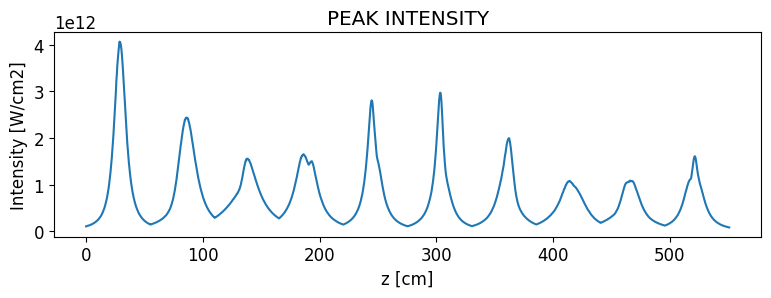

In [140]:
# PLOT PEAK INTENSITY
plt.figure(figsize=size_py_wide) 
plt.title("PEAK INTENSITY")
# plt.plot(z_total.*1e2, cat(dims=1, w_z...).*1e6)
plt.plot(z_total.*1e2, fac.*I_peak_fused)
plt.xlabel("z [cm]")
plt.ylabel("Intensity [W/cm2]")
# plt.ylim(0, 1.2e13)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "caustic.png"), dpi=res) 
end
plt.gcf()

In [141]:
# integrate peak intensity over z for each pass
I_peak_int = zeros(size(I_peak,2))
for ii = 1:size(I_peak, 2)
    I_peak_int[ii] = integrate(z, I_peak[:, ii], SimpsonEven());
end

In [142]:
n2 = params["n2"]
B_int = 2pi/λ0*n2*I_peak_int
B_int .*= PhysData.c*PhysData.ε_0/2

10-element Vector{Float64}:
 7.523576682257073
 6.441618508794681
 5.104582894529341
 5.3212990075475854
 5.301804620102454
 4.8803136338384805
 4.290289192122084
 3.714613202358052
 3.38539322489346
 3.6466456674973857

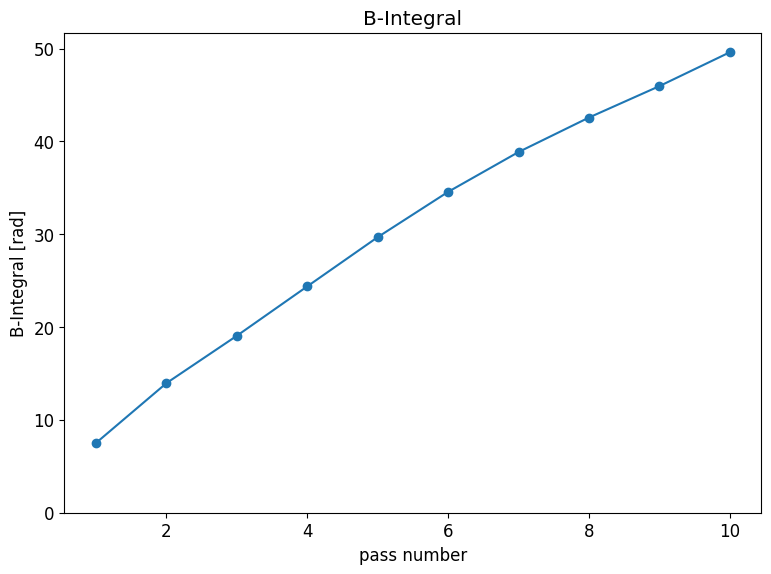

In [143]:
# PLOT B-integral per pass
plt.figure(figsize=size_py) 
plt.title("B-Integral")
plt.plot(1:Npass, cumsum(B_int), marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("B-Integral [rad]")
plt.ylim(0,)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

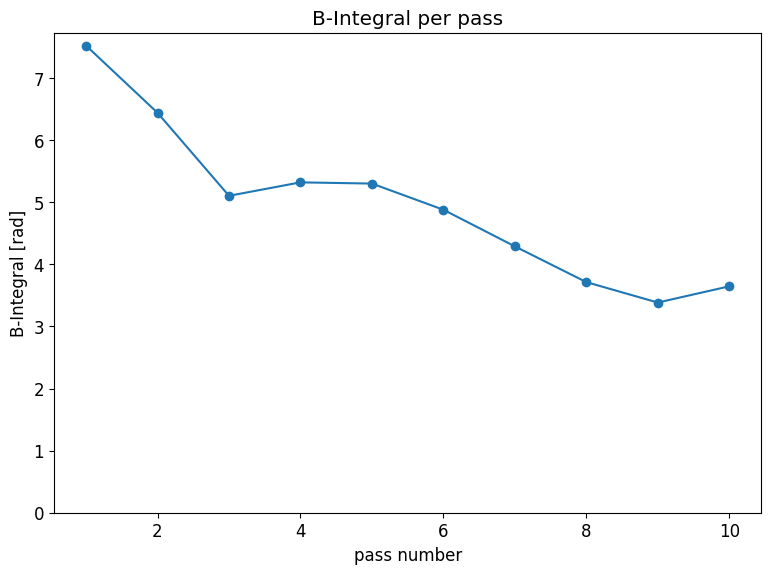

In [144]:
# PLOT B-integral per pass
plt.figure(figsize=size_py) 
plt.title("B-Integral per pass")
plt.plot(1:Npass, B_int, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("B-Integral [rad]")
plt.ylim(0,)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

In [145]:
# Expected accumulated B-Integral based on eq.8 in Viotti et al. 2022
E_pulse = params["E_pulse"]
τ = params["τ"]
k = params["k"]
Nrt = params["Npass"]/2

P_peak = 0.94*E_pulse/τ
B_pass = 4*pi^2*n2*P_peak/λ0^2*(k/Nrt)
B_total = Nrt*B_pass

println("B_pass = ", B_pass)
println("B_total = ", B_total)

B_pass = 2.4284347737935112
B_total = 12.142173868967557
